In [22]:
import utils
import importlib

importlib.reload(utils)

<module 'utils' from '/data/users/zhangjunlei/tyx/reward-by-prm800k/src/utils.py'>

In [8]:
import csv
import matplotlib.pyplot as plt
import random

In [4]:
best_of_n_results = utils.load_jsonl(utils.best_of_n_results_jsonl_path)
best_of_n_results_csv_path = utils.best_of_n_results_jsonl_path.split(".")[0] + ".csv"

In [5]:
with open(best_of_n_results_csv_path, "w") as f:
    writer = csv.writer(f)
    # 写入列名
    writer.writerow(best_of_n_results[0].keys())
    # 写入其他行
    for best_of_n_result in best_of_n_results:
        writer.writerow(best_of_n_result.values())

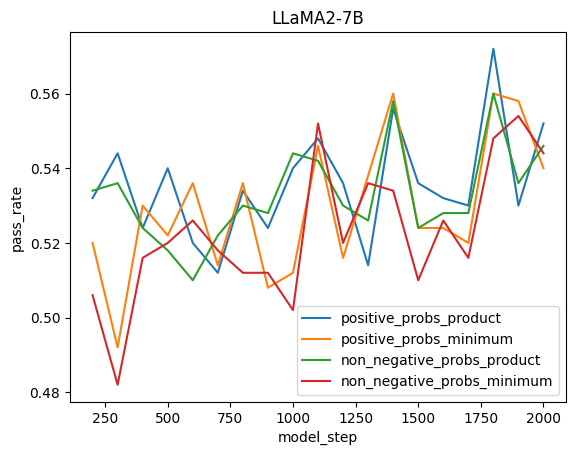

In [46]:
# 1. Consider only the `num_samples_per_problem` largest (16 here) samples.
# 2. The horizontal coordinate is the number of model training steps, `model_step`, and the vertical coordinate is the pass rate, `pass_rate`.
# 3. The vertical coordinate is the pass rate `pass_rate`.
# 4. Draw a curve for each of the `pass_rates` corresponding to `metrics` other than `"majority_voting"`.
# 5. Draw a horizontal dotted line for the `pass_rates` corresponding to `"majority_voting"`.
# data[metric][model_step] = pass_rates


data = {}
for best_of_n_result in best_of_n_results:
    if best_of_n_result["num_samples_per_problem"] < 16:  # best-of-16
        continue

    metric = best_of_n_result["metric"]
    model_step = utils.extract_step_or_epoch_num(best_of_n_result["model_name_or_path"])
    if model_step == None:
        continue
        if metric == "majority_voting":
            model_step = 0
        else:
            model_step = 2040  # 2040 is the last step of the model training
            # continue

    pass_rates = [
        best_of_n_pass_rates[3]
        for best_of_n_pass_rates in best_of_n_result["pass_rates"]
    ]  # best-of-16

    if data.get(metric) is None:
        data[metric] = {}

    data[metric][model_step] = pass_rates
# print(f"data = {data}")

# input: data[metric][model_step] = pass_rates
# output: xs = model_steps, ys = pass_rates[metric], labels = metrics
model_steps = []
all_trial_pass_rates_by_metric = {}
for metric, model_step2pass_rates in data.items():
    # print(f"metric = {metric}")
    # print(f"model_step2pass_rates = {model_step2pass_rates}")
    # all_trial_pass_rates_by_metric[metric] = []
    # for model_step, pass_rates in model_step2pass_rates.items():
    #     pass_rates_by_metric[metric].append(pass_rates)
    if metric == "majority_voting":
        all_trial_pass_rates_by_metric[metric] = model_step2pass_rates[0]
    else:
        # print(sorted(list(model_step2pass_rates.items()), key=lambda x: x[0]))
        model_steps, all_trial_pass_rates_by_metric[metric] = list(
            zip(*sorted(list(model_step2pass_rates.items()), key=lambda x: x[0]))
        )  # ascending by model_step

plt.xlabel("model_step")
plt.ylabel("pass_rate")
plt.title("LLaMA2-7B")
xs = model_steps
for metric, ys in all_trial_pass_rates_by_metric.items():
    if metric == "majority_voting":
        y = ys[0]
        plt.axhline(y=y, color="black", linestyle="--", label=metric)
    else:
        ys = list(zip(*ys))[0]
        plt.plot(xs, ys, label=metric)
plt.legend()
plt.show()